In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm2/sarcasm_dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/contractions/contractions.csv


In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_json("../input/sarcasm2/sarcasm_dataset.json", lines=True)
data

,is_sarcastic,headline
0,1,It feels like just a few days ago it was the l...
1,1,"I love my mom . No matter what we go through ,..."
2,1,Bump that music ... #imtryingtosleep #sarcasm
3,0,Mexican and black jokes are pretty much the sa...
4,0,How to find work you love :
...,...,...
54926,0,Don't be so formal because I'm much older you ...
54927,0,Busy night in work ... She esh ! Bed now then ...
54928,0,yayyy Avicii u haz a new song <3 OMG I can't w...
54929,0,""" you th i nk i'm shit . Well , you're wrong ...."


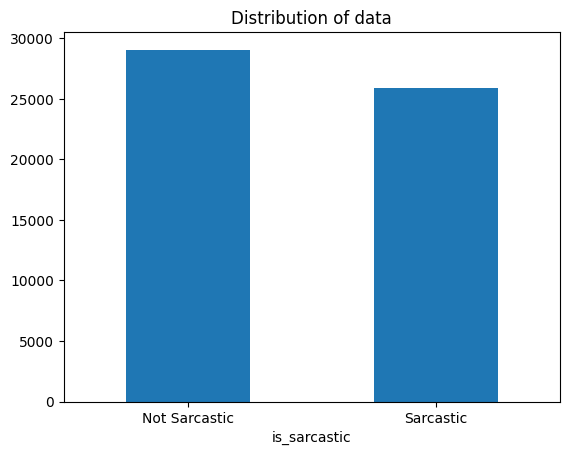

In [4]:
ax = data.groupby('is_sarcastic').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(["Not Sarcastic", "Sarcastic"], rotation=0)

## Preprocessing the Text
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that deep learning algorithms can perform better.

Tweets usually contains a lot of information apart from the text, like mentions, hashtags, urls, emojis or symbols. Since normally, NLP models cannot parse those data, we need to clean up the tweet and replace tokens that actually contains meaningful information for the model.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **'http' or 'https' or 'www'** are replaced by **'<url\>'**.
3. **Replacing Usernames:** Replace @Usernames with word **'<user\>'**. [eg: '@Kaggle' to '<user\>'].
4. **Replacing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. [eg: 'Heyyyy' to 'Heyy']
5. **Replacing Emojis:** Replace emojis by using a regex expression. [eg: ':)' to '<smile\>']
6. **Replacing Contractions:** Replacing contractions with their meanings. [eg: "can't" to 'can not']
7. **Removing Non-Alphabets:** Replacing characters except Digits, Alphabets and pre-defined Symbols with a space.
8. **Removing Stopwords:**  stopwords are often removed from text data in order to focus on the important words that carry the most meaning  such as "the," "and," and "is."
9. **Stemming:** Normalize text by reducing words to their most basic form, so that words with the same meaning but different variations can be identified. For example, the words "running," "runner," and "ran" can all be reduced to the stem "run."

As much as the preprocessing steps are important, the actual sequence is also important while cleaning up the text. For example, removing the punctuations before replacing the urls means the regex expression cannot find the urls. Same with mentions or hashtags. So make sure, the actual sequence of cleaning makes sense.

In [5]:
import re
# Load contractions
contractions = pd.read_csv('/kaggle/input/contractions/contractions.csv', index_col='Contraction', encoding='latin-1')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Define regex patterns
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"  # URLs
userPattern       = '@[^\s]+'                                        # @USERNAME
hashtagPattern    = r'#\S+'                                          # Hashtags
sequencePattern   = r"(.)\1\1+"                                      # Consecutive letters
seqReplacePattern = r"\1\1"                                          # Replace long sequences


# Preprocessing function
def preprocess_apply(tweet):
    tweet = tweet.lower()

    # Remove URLs
    tweet = re.sub(urlPattern, '', tweet)
    # Remove @USERNAME mentions
    tweet = re.sub(userPattern, '', tweet)
    # Remove hashtags and their names
    tweet = re.sub(hashtagPattern, '', tweet)
    # Replace 3+ consecutive letters by 2 letters
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace contractions
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Add spaces around slashes
    tweet = re.sub(r'/', ' / ', tweet)

    return tweet.strip()


In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess(tweet, stem=True):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
# Testing the preprocessing function
print(data['headline'][0])  # Original text
v1 = preprocess_apply(data['headline'][0])
print(v1)  # Preprocessed text

v2=preprocess(v1)
print(v2)

It feels like just a few days ago it was the last day of school . Now it's the end of July . 😐 #sarcasm
it feels like just a few days ago it was the last day of school . now it is the end of july . 😐
feel like day ago last day school end juli


In [9]:
data

,is_sarcastic,headline
0,1,It feels like just a few days ago it was the l...
1,1,"I love my mom . No matter what we go through ,..."
2,1,Bump that music ... #imtryingtosleep #sarcasm
3,0,Mexican and black jokes are pretty much the sa...
4,0,How to find work you love :
...,...,...
54926,0,Don't be so formal because I'm much older you ...
54927,0,Busy night in work ... She esh ! Bed now then ...
54928,0,yayyy Avicii u haz a new song <3 OMG I can't w...
54929,0,""" you th i nk i'm shit . Well , you're wrong ...."


In [10]:
%%time
data['processed_text'] = data.headline.apply(preprocess_apply)

CPU times: user 2.03 s, sys: 5.05 ms, total: 2.04 s
Wall time: 2.04 s


In [11]:
%%time
data['processed_text'] = data.headline.apply(preprocess)

CPU times: user 7.38 s, sys: 2.72 ms, total: 7.39 s
Wall time: 7.39 s


In [12]:
data

,is_sarcastic,headline,processed_text
0,1,It feels like just a few days ago it was the l...,feel like day ago last day school end juli sar...
1,1,"I love my mom . No matter what we go through ,...",love mom matter go matter much argu know end a...
2,1,Bump that music ... #imtryingtosleep #sarcasm,bump music imtryingtosleep sarcasm
3,0,Mexican and black jokes are pretty much the sa...,mexican black joke pretti much heard juan hear...
4,0,How to find work you love :,find work love
...,...,...,...
54926,0,Don't be so formal because I'm much older you ...,formal much older think nice ask help pls tell...
54927,0,Busy night in work ... She esh ! Bed now then ...,busi night work esh bed babyk got ta stop call...
54928,0,yayyy Avicii u haz a new song <3 OMG I can't w...,yayyy avicii u haz new song 3 omg wa remix voc...
54929,0,""" you th i nk i'm shit . Well , you're wrong ....",th nk shit well wrong caus champagn shit till ...


In [13]:
labels = data.is_sarcastic.values
sentences = data.processed_text.values

In [14]:
from transformers import RobertaTokenizer, TFRobertaModel
PRE_TRAINED_MODEL_NAME = 'roberta-base' #'bert-base-uncased'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)  #BertTokenizer

def encoder(sentences):
    ids = []
    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=16,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=False
        )
        ids.append(encoding['input_ids'])
    return ids

# Split data
train_sents, test_sents, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.15)

# Encode sentences
train_ids = encoder(train_sents)
test_ids = encoder(test_sents)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [15]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

In [16]:
#bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
roberta_encoder = TFRobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
#embedding = bert_encoder([input_word_ids])
embedding = roberta_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    
model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [17]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 16)]              0         
 )                                                               
                                                                 
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPo   124645632 
 aModel)                     olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 16, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [18]:
history = model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/3


I0000 00:00:1734382767.053791     130 service.cc:145] XLA service 0x7f5d8c61ab00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734382767.053864     130 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734382767.053871     130 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734382767.258896     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1460/1460 [==============================] - 262s 141ms/step - loss: 0.3182 - accuracy: 0.8468 - val_loss: 0.2892 - val_accuracy: 0.8665
Epoch 2/3
1460/1460 [==============================] - 202s 138ms/step - loss: 0.2680 - accuracy: 0.8801 - val_loss: 0.2731 - val_accuracy: 0.8779
Epoch 3/3
1460/1460 [==============================] - 202s 138ms/step - loss: 0.2334 - accuracy: 0.9023 - val_loss: 0.2722 - val_accuracy: 0.8820


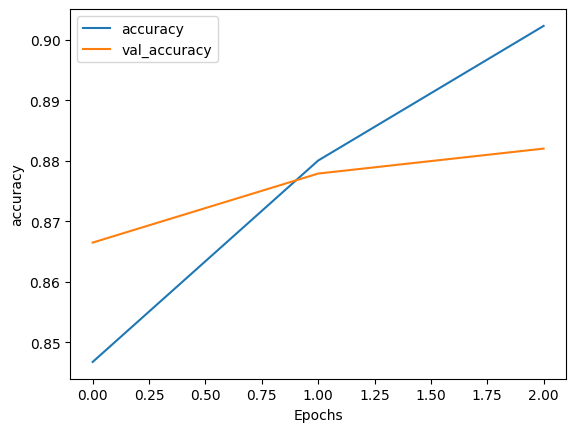

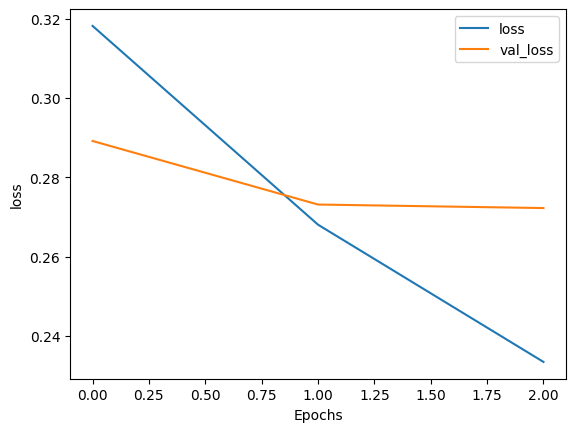

In [19]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [23]:
# Function to preprocess, clean, and encode input sentences
def preprocess_and_encode(sentences, tokenizer, max_length=16):
    encoded_ids = []
    for sentence in sentences:
        # Preprocess the sentence
        cleaned_sentence = preprocess_apply(sentence)
        
        # Encode the cleaned sentence
        encoding = tokenizer.encode_plus(
            cleaned_sentence,
            max_length=max_length,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=False
        )
        encoded_ids.append(encoding['input_ids'])
    return tf.convert_to_tensor(encoded_ids)

In [24]:
# Example sentences to predict
example_sentences = [
    "I just love waiting in traffic for hours!",
    "The weather is perfect today, finally a break from the rain.",
    "Oh great, another meeting that could have been an email."
]

# Preprocess and encode the example sentences
example_ids = preprocess_and_encode(example_sentences, tokenizer)

# Make predictions
predictions = model.predict(example_ids)

# Post-process predictions
for sentence, pred in zip(example_sentences, predictions):
    sarcasm_prob = pred[0]
    label = "Sarcastic" if sarcasm_prob > 0.5 else "Not Sarcastic"
    print(f"Sentence: \"{sentence}\"")
    print(f"Predicted Sarcasm Probability: {sarcasm_prob:.4f}")
    print(f"Predicted Label: {label}\n")

1/1 [==============================] - 0s 43ms/step
Sentence: "I just love waiting in traffic for hours!"
Predicted Sarcasm Probability: 0.0300
Predicted Label: Not Sarcastic

Sentence: "The weather is perfect today, finally a break from the rain."
Predicted Sarcasm Probability: 0.0328
Predicted Label: Not Sarcastic

Sentence: "Oh great, another meeting that could have been an email."
Predicted Sarcasm Probability: 0.0252
Predicted Label: Not Sarcastic



In [25]:
from sklearn.metrics import classification_report

# Generate predictions on the test set
test_predictions = model.predict(test_ids)
# Convert probabilities to binary labels (threshold: 0.5)
test_predictions = (test_predictions.flatten() > 0.5).astype(int)

# Print the classification report
print(classification_report(test_labels.numpy(), test_predictions, target_names=["Not Sarcastic", "Sarcastic"]))

258/258 [==============================] - 11s 43ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.88      0.90      0.89      4321
    Sarcastic       0.88      0.86      0.87      3919

     accuracy                           0.88      8240
    macro avg       0.88      0.88      0.88      8240
 weighted avg       0.88      0.88      0.88      8240

